## Chest-xRay classification

<p >In this project we will try to build a classifier that tries to predict image for patients and we will use a dataset contains on X-ray for the chest and there is two class <br>0-Normal<br>1-Pneumonia<br>the data suffering from imbalanced data and we will try to overcome this problem by using two techniques <br> 1-over-samples<br>2-data augmentation<br>
and We will explain that later on this note.
and we will use three algorithms to build a classifier a Support vector machine (SVM) , k nearest neighbor (KNN) and a decision tree.  
</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import os 
import cv2
import imgaug.augmenters as IA
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import  SMOTE
from collections  import Counter
# from keras.preprocessing.image import ImageDataGenerator


train_path = "train"
test_path = "test"
val_path = "val"


img_size = 28 
seed = 42 
# test_size = 0.2


In [2]:
def plot_confusion_matrix(actual,pred): # Plot the confusion matrix 
    sn.heatmap(confusion_matrix(actual ,pred),annot=True, yticklabels=['NORMAL','PNEUMONIA'],xticklabels=['NORMAL','PNEUMONIA']
               ,fmt="g")
    plt.tight_layout()
    plt.show()


### Create Training data set 

the data is raw image first we need to read image in gray sacle then we resize the image to 28x28 becuase the image have a diffrient dimsonsion. For that we will use openCV library (cv2) in we will save it as csv file.

In [3]:
def create_dataset(dir_path):
    X = []
    y = []
    Classes = ["NORMAL","PNEUMONIA"]
    for i in range(len(Classes)):
        path = os.path.join(dir_path,Classes[i]) # path to each class
        print("Reading Imgae in GrayScale class {}".format(Classes[i]))
        for image in os.listdir(path):
            try:
                image_path = os.path.join(path,image) # image path
                
                image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE) # Read Image in gray sacle
                
                image = cv2.resize(image,(img_size,img_size))# reszie image by 28x28
                
                X.append(image.flatten())# flat the image array to end up  array in 2d-array 
                
                y.append(i) # label for image 
                    
            except Exception as e:
                pass
        print("Reading Image for class {} is done".format(Classes[i]))
    
    return X , y 


In [4]:
if not os.path.exists("Train.csv"):
    Train_X , Train_y = create_dataset(dir_path=train_path)
    Train_X = np.array(Train_X)
    Train_y = np.array(Train_y)

    train_set = pd.DataFrame(data=Train_X)
    train_set["target"] = Train_y
    train_set.to_csv("Train.csv",index=False)
else:
    train_set = pd.read_csv("Train.csv")
    print("Data is loaded !!!")

Data is loaded !!!


### Create Test data 

#### some text will be here

In [5]:
if not os.path.exists("Test.csv"):
    Test_X , Test_y = create_dataset(dir_path=test_path)
    Test_X = np.array(Test_X)
    Test_y = np.array(Test_y)

    test_set = pd.DataFrame(data=Test_X)
    test_set["target"] = Test_y
    test_set.to_csv("Test.csv",index=False)
else:
    test_set = pd.read_csv("Test.csv")

    print("Data is loaded !!!")

Data is loaded !!!


In [6]:
if not os.path.exists("val.csv"):
    val_X , val_y = create_dataset(dir_path=val_path)
    val_X = np.array(val_X)
    val_y = np.array(val_y)

    val_set = pd.DataFrame(data=val_X)
    val_set["target"] = val_y
    val_set.to_csv("val.csv",index=False)
else:
    val_set = pd.read_csv("val.csv")

    print("Data is loaded !!!")

Data is loaded !!!


### Imbalanced data 
It's normal to have imbalanced data, especially in medical data, and for that, we have for normal class we have 1341 images and for Pneumonia have 3875 images in total we have 5216 images.

1    3875
0    1341
Name: target, dtype: int64


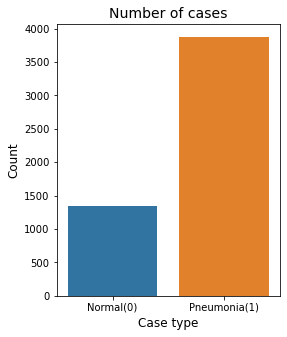

In [7]:
y = train_set['target'].value_counts()
print(y)
plt.figure(figsize=(4,5))
sn.barplot(x=y.index, y = y.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(y.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [8]:
x_train = train_set.drop('target', axis='columns')
y_train = train_set['target']

x_train = x_train / 255 # sacle the data to end up with vlaues between (0,1)


xTest = test_set.drop('target', axis='columns')
yTest = test_set['target']
xTest = xTest / 255

### classifier with imbalanced data 
First, we want to build a model using the imbalanced data and we will show how that affects on the model and we will show what the accuracy we got and how much we got for the precision and recall.

Accuracy on valdation data: 0.75
Accuracy on test data: 0.7676282051282052
Precision for test data: 0.7324478178368121
Recall: for test data 0.9897435897435898


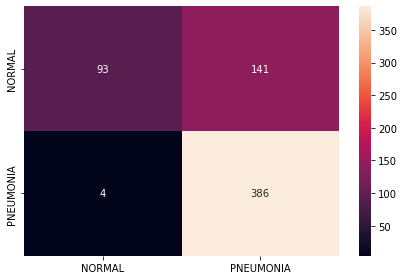

In [9]:

svc = SVC()
svc.fit(x_train,y_train)

pred = svc.predict(val_set.drop('target',axis='columns')/255)
pred2 = svc.predict(xTest)


print('Accuracy on valdation data:',accuracy_score(val_set['target'],pred))

print('Accuracy on test data:',accuracy_score(yTest,pred2))
print('Precision for test data:',metrics.precision_score(yTest,pred2))
print('Recall: for test data',metrics.recall_score(yTest,pred2))

plot_confusion_matrix(actual=yTest,pred=pred2)

as we can see we got for the validation set 75% accuracy that good but we got on test data 76% accuracy and we got for test data precision 72% and for recall 98% which means the model will predict incorrect labels as we can see from confusion matrix it predict for normal class 90 from 234 and for Pneumonia it's only 4 got incorrect.

### Over-samples (SMOTE)

Smote stands for synthetic minority over-sampling technique the idea behind this is to duplicate the samples in the minority class but rather than duplicate with the replacement it will create a synthetic example and it's done on feature space. synthetic example it will be created using k-nearest-neighbor (k = 5) first it will chose at random on sample then find the K-nearest neighbor then choice one of it's k-nearest neighbor, new sample will be calculated as following <br><br>$new sample = x_i  + random(0,1) * (x_i - x_j) $

where:<br>
$x_i$: random sample <br>
$x_j$ : one of nearest neighbor from $x_i$

we will use smote algorithm from library imblearn to help us to use SMOTE.

0    3875
1    3875
Name: target, dtype: int64


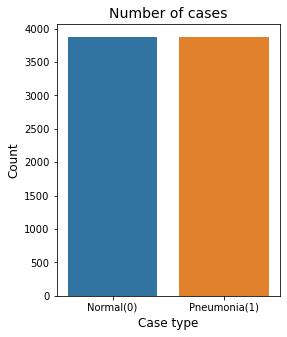

In [10]:
smote = SMOTE(random_state=42)

X_smote , y_smote = smote.fit_resample(x_train,y_train)

count = y_smote.value_counts()
print(count)
plt.figure(figsize=(4,5))
sn.barplot(x=count.index, y = count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

### Data Augmentation 
the second technique is data augmentation is widely used in image preprocessing it's used to generate a new sample in a minority class and it's done by performing some operations on the same image like rotation, zoom in/out, and flipping the image and more. 
and we will use three operation which is <br>1-horizontal flips <br> 2- rotation by 20 degree <br>3-brightness <br>4-zoom in<br>
and we will use imgaug library to help us.

In [11]:
aug = IA.OneOf([
    IA.Fliplr(), # horizontal flips
    IA.Affine(rotate=30), # roatation
#     IA.Multiply((1.2, 1.5)),#random brightness
    IA.Affine(scale=0.3) ]) # zoom in  

In [12]:
def create_dataset_aug():
    X = []
    y = []
    count =0
    Classes = ["NORMAL","PNEUMONIA"]
    for i in range(len(Classes)):
        path = os.path.join(train_path,Classes[i]) # path to each class
        print("Reading Imgae in GrayScale class {}".format(Classes[i]))
        for image in os.listdir(path):
            try:
                image_path = os.path.join(path,image) # image path
                
                image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE) # Read Image in gray sacle
                
                image = cv2.resize(image,(img_size,img_size))# reszie image by 28x28
                if i == 0 and count != 1268:
                    image_aug1= aug.augment_image(image)
                    image_aug2= aug.augment_image(image)
                    X.append(image_aug1.flatten())# flat the image array to end up  array in 2d-array 
                    X.append(image_aug2.flatten())# flat the image array to end up  array in 2d-array 
                    y.append(i)
                    y.append(i)
                    count +=1
                
                X.append(image.flatten())# flat the image array to end up  array in 2d-array 
                
                y.append(i) # label for image 
                    
            except Exception as e:
                pass
        print("Reading Image for class {} is done".format(Classes[i]))
    
    return X , y 

In [13]:
if not os.path.exists("Train_aug.csv"):
    TrainAug_X , TrainAug_y = create_dataset_aug()
    TrainAug_X = np.array(TrainAug_X)
    TrainAug_y = np.array(TrainAug_y)

    TrainAug_set = pd.DataFrame(data=TrainAug_X)
    TrainAug_set["target"] = TrainAug_y
    TrainAug_set.to_csv("Train_aug.csv",index=False)
else:
    TrainAug_set = pd.read_csv("Train_aug.csv")
    print("Data is loaded !!!")

Data is loaded !!!


In [14]:
TrainAug_set.head()

,pixel 0,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,...,pixel 775,pixel 776,pixel 777,pixel 778,pixel 779,pixel 780,pixel 781,pixel 782,pixel 783,target
0,149,149,142,150,160,155,170,183,170,166,...,200,197,194,187,169,155,140,122,123,0
1,149,149,142,150,160,155,170,183,170,166,...,200,197,194,187,169,155,140,122,123,0
2,17,69,97,113,140,113,102,70,252,79,...,189,130,135,150,175,46,18,31,32,0
3,28,87,88,111,50,51,25,23,25,31,...,206,187,179,165,139,92,35,0,0,0
4,28,87,88,111,50,51,25,23,25,31,...,206,187,179,165,139,92,35,0,0,0


0    3877
1    3875
Name: target, dtype: int64


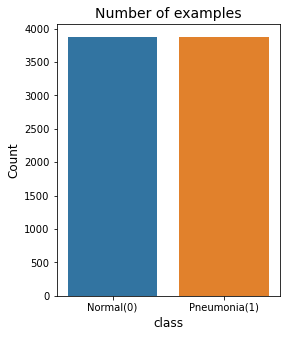

In [15]:
X_Aug = TrainAug_set.drop('target',axis='columns')
y_Aug = TrainAug_set['target']
X_Aug = X_Aug/255
count = y_Aug.value_counts()
print(count)
plt.figure(figsize=(4,5))
sn.barplot(x=count.index, y = count.values)
plt.title('Number of examples', fontsize=14)
plt.xlabel('class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

### Support vector machine (SVM)
The first classifier we have is SVM first we will implement SVM using the default parameter then we will try different parameters to achieve the best result on our test data

In [16]:
svc_overSamples = SVC()
svc_overSamples.fit(X_smote,y_smote)

svc_Aug = SVC()
svc_Aug.fit(X_Aug,y_Aug)

SVC()

OverSamples
Accuracy on test data: 0.782051282051282
Precision for test data: 0.75
Recall: for test data 0.9769230769230769


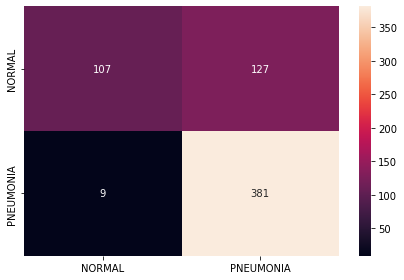

Data augmentation
Accuracy on test data: 0.7852564102564102
Precision for test data: 0.7519685039370079
Recall: for test data 0.9794871794871794


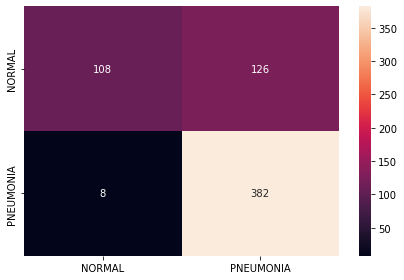

In [17]:
pred_over = svc_overSamples.predict(xTest)
pred_aug = svc_Aug.predict(xTest)

print("OverSamples")

print('Accuracy on test data:',accuracy_score(yTest,pred_over))
print('Precision for test data:',metrics.precision_score(yTest,pred_over))
print('Recall: for test data',metrics.recall_score(yTest,pred_over))

plot_confusion_matrix(actual=yTest,pred=pred_over)

print("Data augmentation")
print('Accuracy on test data:',accuracy_score(yTest,pred_aug))
print('Precision for test data:',metrics.precision_score(yTest,pred_aug))
print('Recall: for test data',metrics.recall_score(yTest,pred_aug))

plot_confusion_matrix(actual=yTest,pred=pred_aug)



### SVM Parameters 
There are several parameters for SVM but we are interested in one which is C, we will try C on 4 values {0.1,1,10,100} and we will see the accuracy of test data <br>
C: cost of misclassified examples 


In [18]:
clfs =[]
C = [0.1, 1, 10, 100]
for i in range(4):
    clfs.append(SVC(C=C[i],gamma='auto').fit(X_smote,y_smote).predict(xTest))

In [19]:
acc_test = []
for i in range(4):
    acc_test.append(accuracy_score(yTest,clfs[i]))
print(acc_test)

[0.8317307692307693, 0.7900641025641025, 0.782051282051282, 0.7740384615384616]


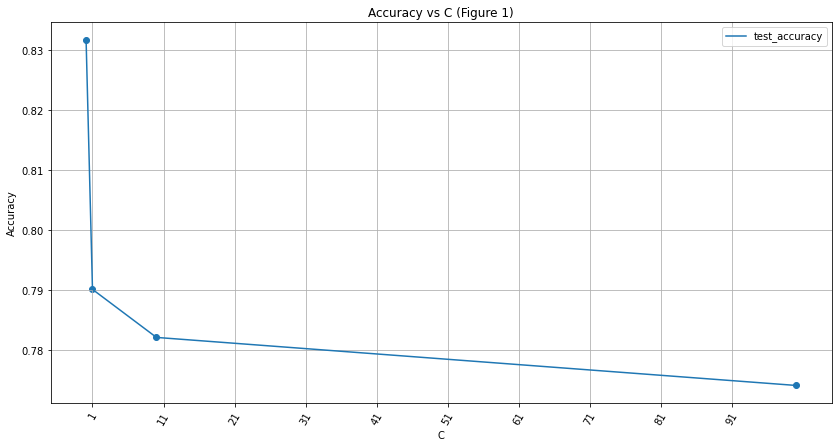

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(C, acc_test, label='test_accuracy')
plt.scatter(C, acc_test)

plt.xticks(ticks=np.arange(1,100,10), rotation=60)
plt.grid()
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title('Accuracy vs C (Figure 1)')
plt.show()

From the graph we can say that the best accuracy is 83% and C = 0.1, now let fit the model

In [21]:
svc_overSample = SVC(C=0.1,gamma='auto')
svc_overSample.fit(X_smote,y_smote)


SVC(C=0.1, gamma='auto')

OverSamples
Accuracy on test data: 0.8317307692307693
Precision for test data: 0.8501228501228502
Recall: for test data 0.8871794871794871


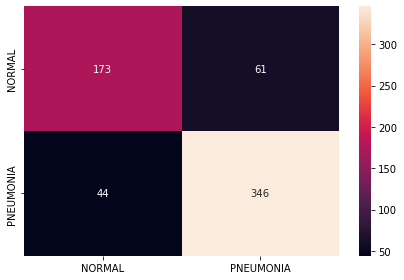

In [22]:
pred_over = svc_overSample.predict(xTest)

print("OverSamples")

print('Accuracy on test data:',accuracy_score(yTest,pred_over))
print('Precision for test data:',metrics.precision_score(yTest,pred_over))
print('Recall: for test data',metrics.recall_score(yTest,pred_over))

plot_confusion_matrix(actual=yTest,pred=pred_over)


In [23]:
clfs =[]
C = [0.1, 1, 10, 100]
for i in range(4):
    clfs.append(SVC(C=C[i]).fit(X_Aug,y_Aug).predict(xTest))

In [24]:
acc_test2 = []
for i in range(4):
    acc_test2.append(accuracy_score(yTest,clfs[i]))
print(acc_test2)

[0.7948717948717948, 0.7852564102564102, 0.780448717948718, 0.7836538461538461]


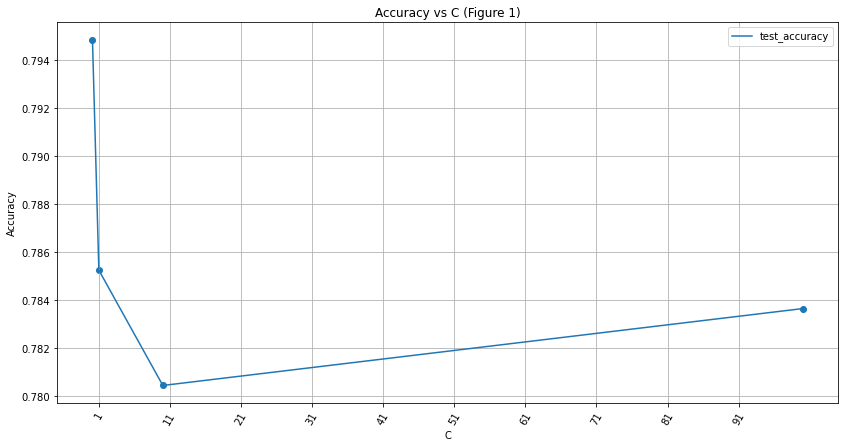

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(C, acc_test2, label='test_accuracy')
plt.scatter(C, acc_test2)

plt.xticks(ticks=np.arange(1,100,10), rotation=60)
plt.grid()
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title('Accuracy vs C (Figure 1)')
plt.show()

In [26]:
svc_augm = SVC(C=0.1)
svc_augm.fit(X_Aug,y_Aug)


SVC(C=0.1)

Data augmentation
Accuracy on test data: 0.7948717948717948
Precision for test data: 0.7641129032258065
Recall: for test data 0.9717948717948718


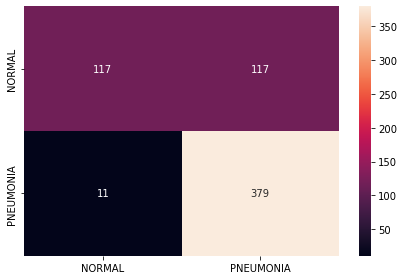

In [27]:
pred_aug = svc_augm.predict(xTest)

print("Data augmentation")

print('Accuracy on test data:',accuracy_score(yTest,pred_aug))
print('Precision for test data:',metrics.precision_score(yTest,pred_aug))
print('Recall: for test data',metrics.recall_score(yTest,pred_aug))

plot_confusion_matrix(actual=yTest,pred=pred_aug)


### RandomForest 
RandomForest is an ensemble method that allows us to have a set of decision trees, and it also doesn't suffer from an overfitting issue.
and it's done by splitting the dataset and training a decision tree classifier then when it predicts it uses all of the trees that we have in RandomForest to make the prediction. And we will use RandomForestClassifier from sklearn library and we will have about 100 decision tree in our forest.

In [28]:
Forest_over = RandomForestClassifier(class_weight="balanced_subsample",bootstrap=True,criterion='entropy',n_estimators=100,random_state=0,verbose=1,n_jobs=4)
# class_weight="balanced_subsample"
Forest_over = Forest_over.fit(X_smote, y_smote)

y_predict_test = Forest_over.predict(xTest)




[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of the test sample = 83.0%
Precision for test data: 0.7896907216494845
Recall: for test data 0.982051282051282


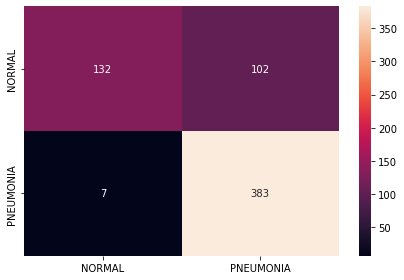

In [29]:
print(f'Accuracy of the test sample = {round(accuracy_score(yTest, y_predict_test), 2)*100}%')
print('Precision for test data:',metrics.precision_score(yTest,y_predict_test))
print('Recall: for test data',metrics.recall_score(yTest,y_predict_test))

plot_confusion_matrix(yTest,y_predict_test)

In [30]:
Forest_aug =RandomForestClassifier(bootstrap=True,criterion='entropy',n_estimators=100,random_state=10,verbose=1,n_jobs=4)
Forest_aug = Forest_aug.fit(X_Aug, y_Aug)

y_predict_test2 = Forest_aug.predict(xTest)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of the test sample = 81.0%
Precision for test data: 0.7735470941883767
Recall: for test data 0.9897435897435898


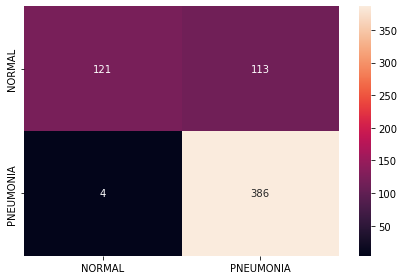

In [31]:
print(f'Accuracy of the test sample = {round(accuracy_score(yTest, y_predict_test2), 2)*100}%')
print('Precision for test data:',metrics.precision_score(yTest,y_predict_test2))
print('Recall: for test data',metrics.recall_score(yTest,y_predict_test2))

plot_confusion_matrix(yTest,y_predict_test2)

## KNN 


In [80]:
# clfs_knn = []
# data = ['Over-sample','data augmentation']

clfs_knn1=(KNeighborsClassifier(metric='manhattan').fit(X_smote,y_smote))
clfs_knn2=(KNeighborsClassifier(metric='manhattan').fit(X_Aug,y_Aug))

In [81]:
over_knn = clfs_knn1
aug_knn = clfs_knn2

In [82]:
over_predK   = over_knn.predict(xTest)
aug_predK    = aug_knn.predict(xTest)


Accuracy on test data is (Over sample (smote) ) 0.8605769230769231
Precision for test data: 0.8615751789976134
Recall: for test data 0.9256410256410257


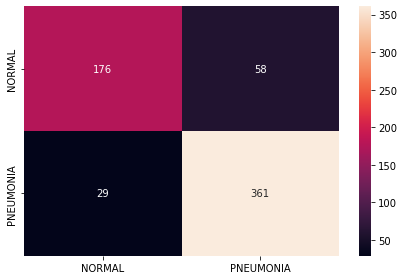

Accuracy on test data is (data augmentation ) 0.7772435897435898
Precision for test data: 0.7381404174573055
Recall: for test data 0.9974358974358974


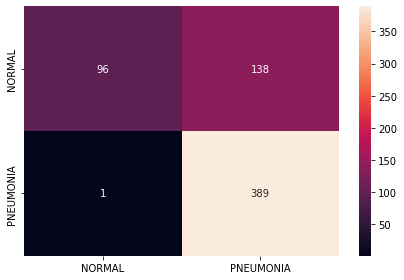

In [83]:
print("Accuracy on test data is (Over sample (smote) )",accuracy_score( yTest,over_predK))



print('Precision for test data:',metrics.precision_score(yTest,over_predK))

print('Recall: for test data',metrics.recall_score(yTest,over_predK))
plot_confusion_matrix(yTest,over_predK)


print("Accuracy on test data is (data augmentation )",accuracy_score( yTest,aug_predK))
print('Precision for test data:',metrics.precision_score(yTest,aug_predK))
print('Recall: for test data',metrics.recall_score(yTest,aug_predK))
plot_confusion_matrix(yTest,aug_predK)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


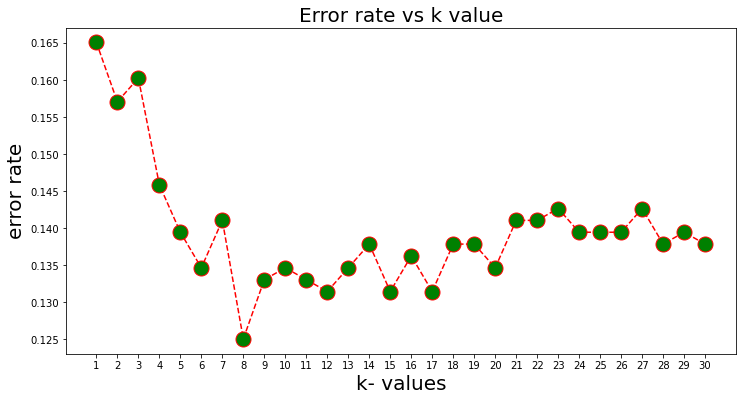

Minimum error:- 0.125 at K = 8


In [91]:

error_rate=[]#list that will store the average error rate value of k
for i in range (1,31):  #Took the range of k from 1 to 30
    print(i)
    clf=KNeighborsClassifier(n_neighbors=i,metric='manhattan',n_jobs=2)
    clf.fit(X_smote,y_smote)
    predict_i=clf.predict(xTest)
    error_rate.append(np.mean(predict_i!=yTest))
#plotting the error rate vs k graph 
plt.figure(figsize=(12,6))
plt.plot(range(1,31),error_rate,marker="o",markerfacecolor="green",
         linestyle="dashed",color="red",markersize=15)
plt.title("Error rate vs k value",fontsize=20)
plt.xlabel("k- values",fontsize=20)
plt.ylabel("error rate",fontsize=20)
plt.xticks(range(1,31))
plt.show()
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)

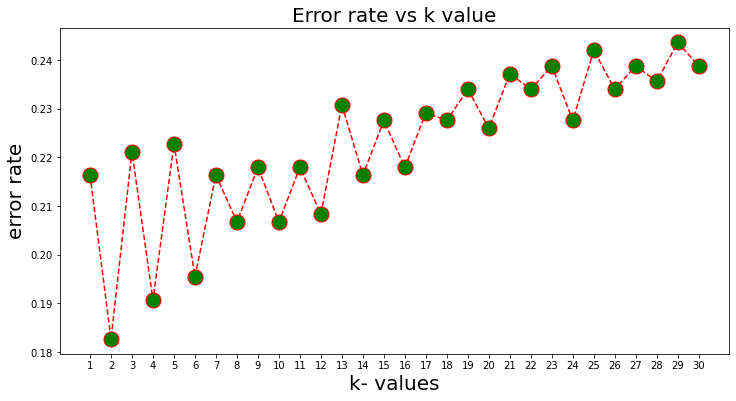

Minimum error:- 0.18269230769230768 at K = 2


In [92]:
error_rate=[]#list that will store the average error rate value of k
for i in range (1,31):  #Took the range of k from 1 to 30
    clf=KNeighborsClassifier(n_neighbors=i,metric='manhattan',n_jobs=2)
    clf.fit(X_Aug,y_Aug)
    predict_i=clf.predict(xTest)
    error_rate.append(np.mean(predict_i!=yTest))
#plotting the error rate vs k graph 
plt.figure(figsize=(12,6))
plt.plot(range(1,31),error_rate,marker="o",markerfacecolor="green",
         linestyle="dashed",color="red",markersize=15)
plt.title("Error rate vs k value",fontsize=20)
plt.xlabel("k- values",fontsize=20)
plt.ylabel("error rate",fontsize=20)
plt.xticks(range(1,31))
plt.show()
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)


Accuracy on test data is (Over sample (smote) ) 0.875
Precision for test data: 0.8861386138613861
Recall: for test data 0.9179487179487179


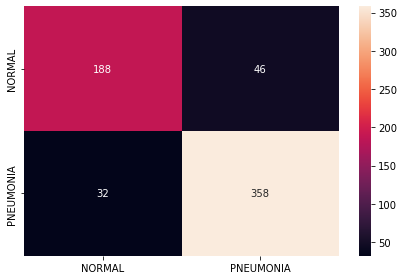

Accuracy on test data is (data augmentation ) 0.8173076923076923
Precision for test data: 0.7875
Recall: for test data 0.9692307692307692


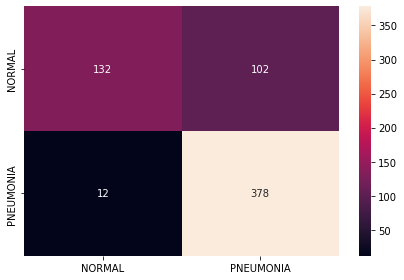

In [93]:
clfs_knn1=(KNeighborsClassifier(n_neighbors=8 ,metric='manhattan').fit(X_smote,y_smote))
clfs_knn2=(KNeighborsClassifier(n_neighbors=2,metric='manhattan').fit(X_Aug,y_Aug))

over_knn1 = clfs_knn1
aug_knn1 = clfs_knn2

over_predK   = over_knn1.predict(xTest)
aug_predK    = aug_knn1.predict(xTest)

print("Accuracy on test data is (Over sample (smote) )",accuracy_score( yTest,over_predK))
print('Precision for test data:',metrics.precision_score(yTest,over_predK))

print('Recall: for test data',metrics.recall_score(yTest,over_predK))
plot_confusion_matrix(yTest,over_predK)

print("Accuracy on test data is (data augmentation )",accuracy_score( yTest,aug_predK))
print('Precision for test data:',metrics.precision_score(yTest,aug_predK))
print('Recall: for test data',metrics.recall_score(yTest,aug_predK))
plot_confusion_matrix(yTest,aug_predK)
